## DATA PREPROCESSING AND MODELLING OF THE BOOKING STATUS HOTEL
#### =======================================================================

### MODEL DEPLOYMENT MID TERM 4th SEMESTER

In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pickle

import warnings
warnings.filterwarnings('ignore')

In [61]:
df = pd.read_csv("Dataset_B_hotel.csv")
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0.0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0.0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0.0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0.0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0.0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     35368 non-null  object 
 6   required_car_parking_space            35005 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

There are several conditions that may become several errors on the data processing and model development, such as:  
1. missing values at several columns  
2. categorical column yang memiliki tipe integer  

Therefore, we need to explore further more through data exploration and manipulation to have a better quality of model.

**EDA ON DATA'S DISTRIBUTION**

I. Numerical Independent Data Distribution

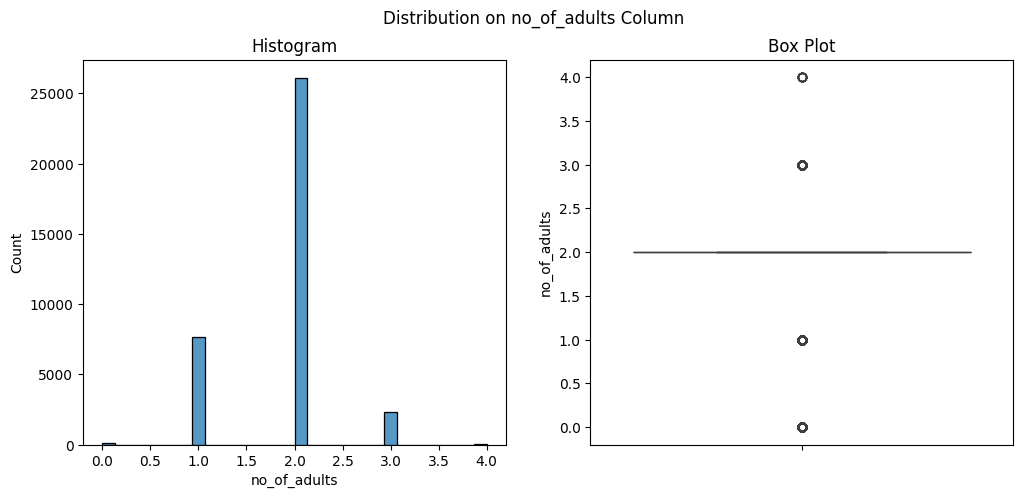

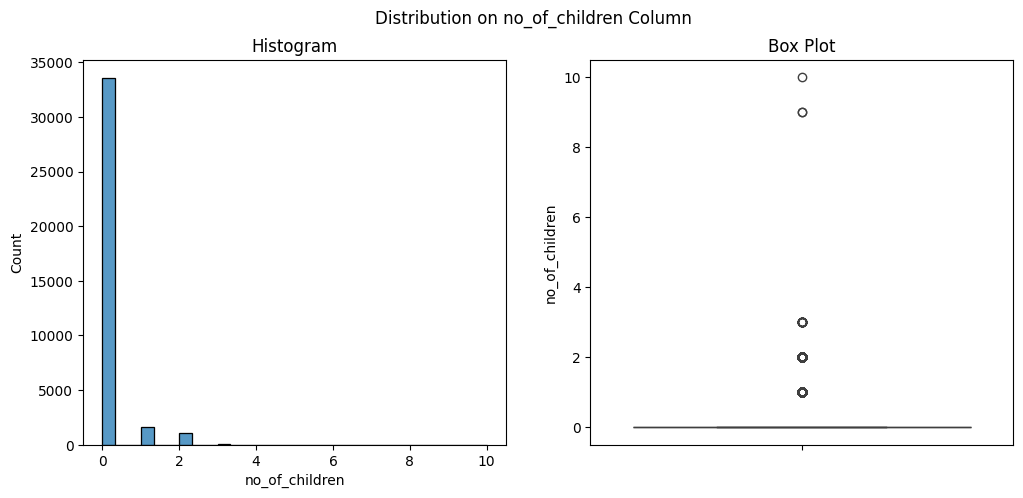

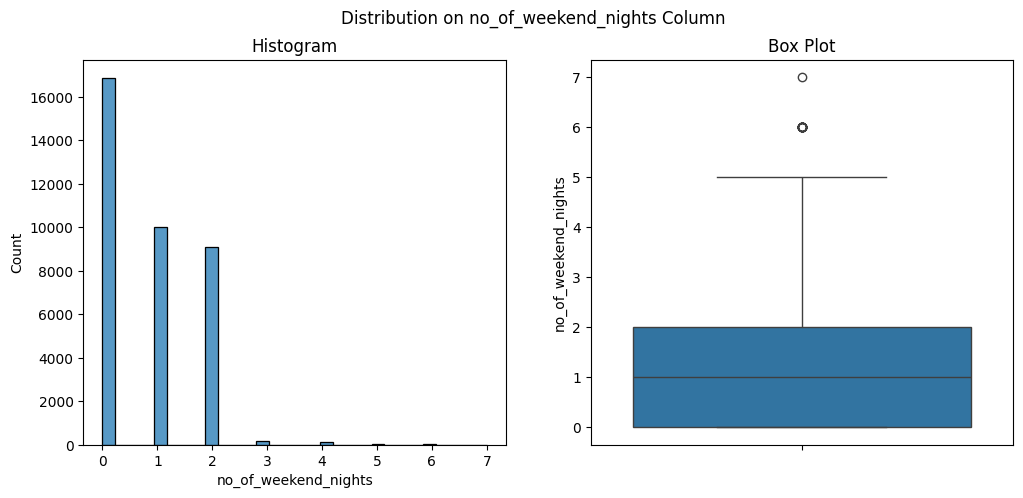

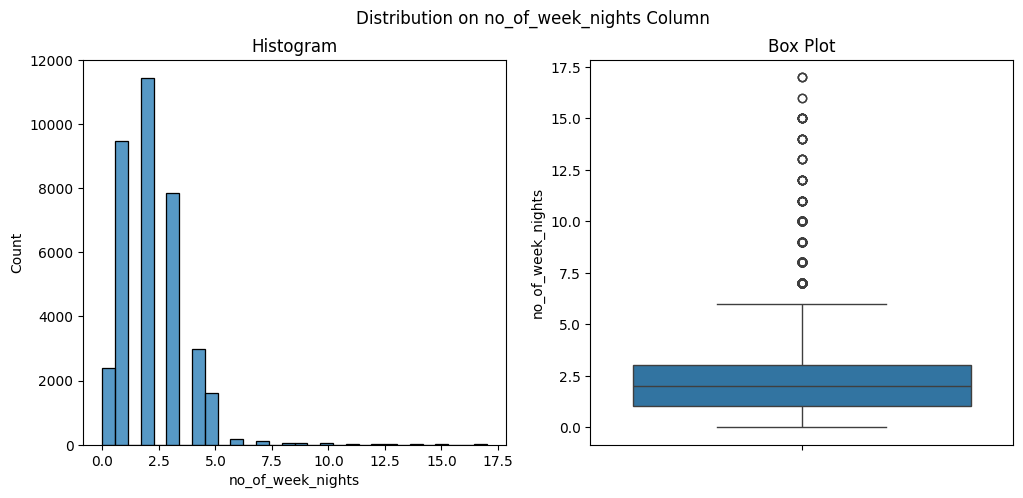

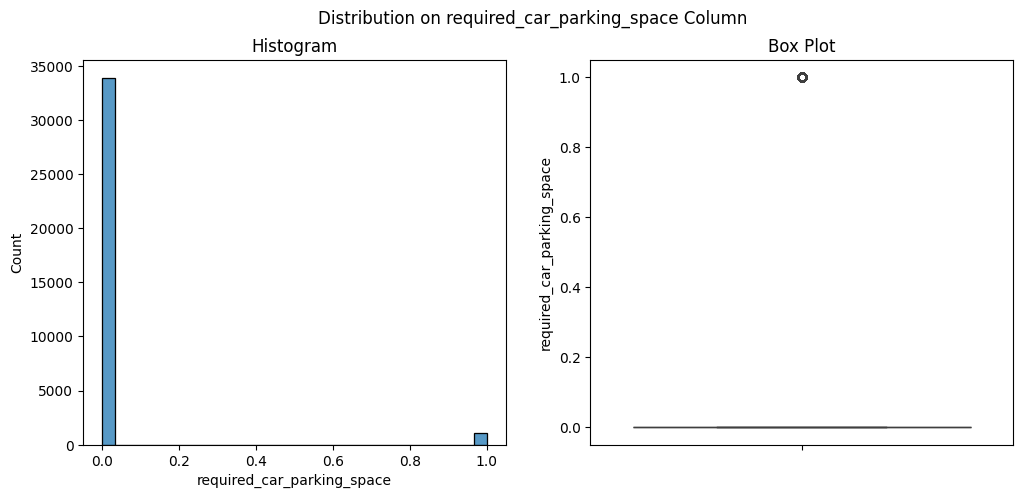

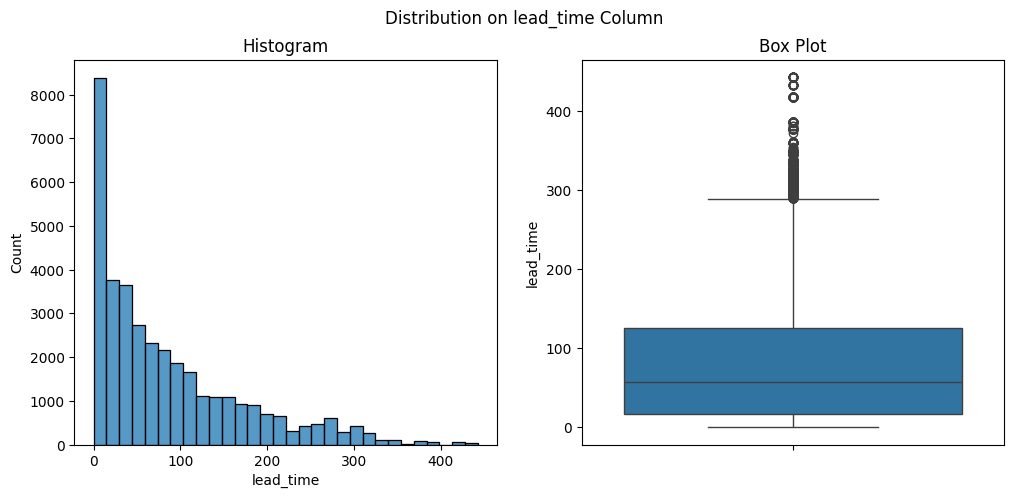

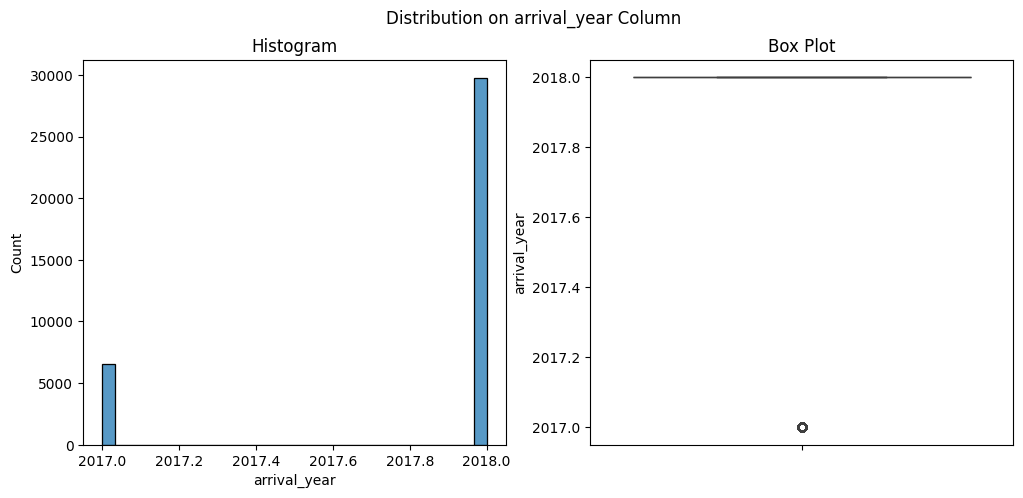

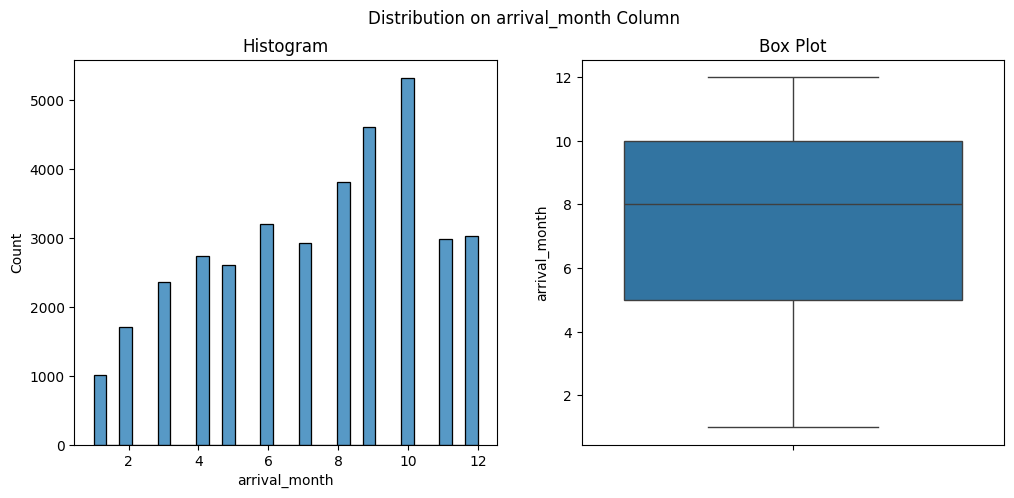

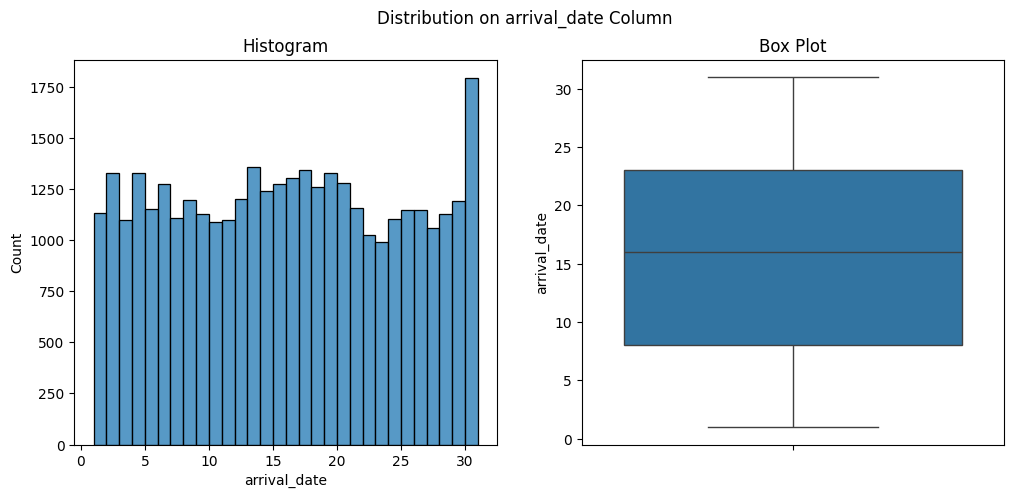

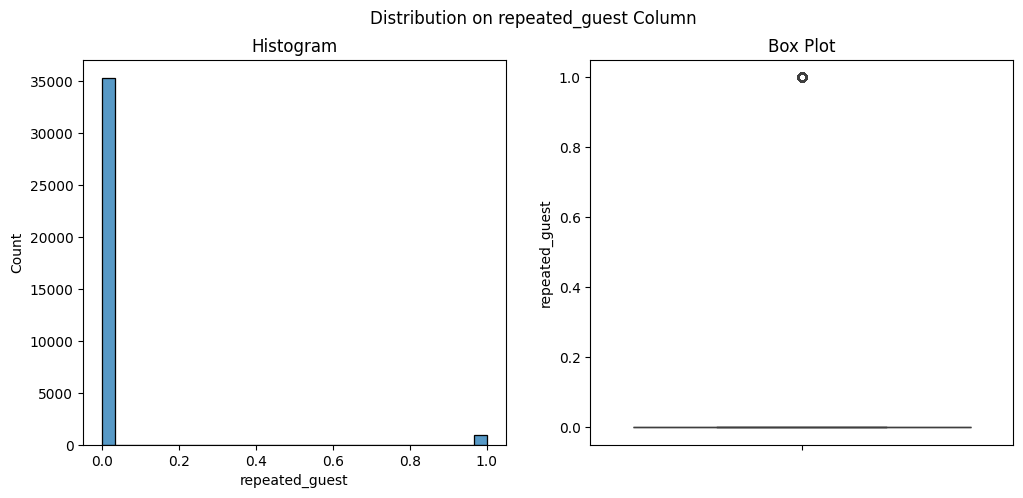

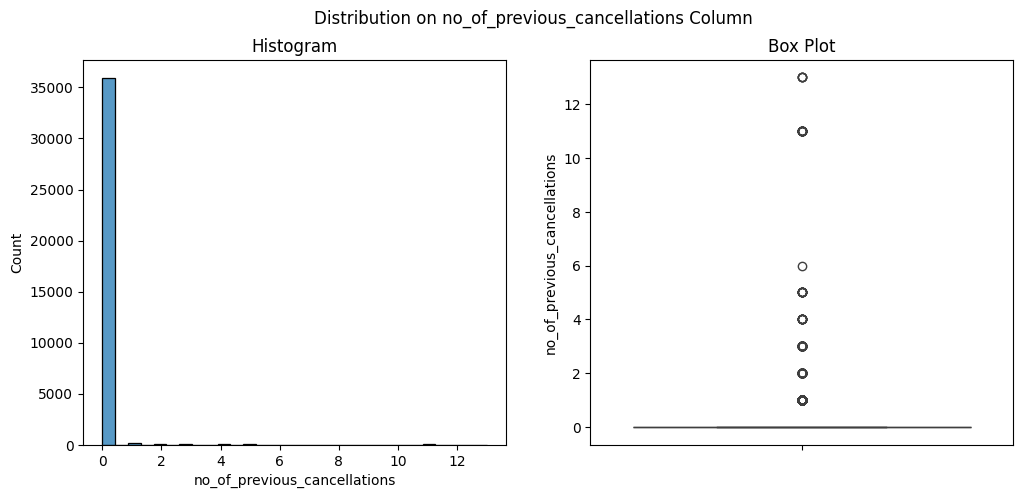

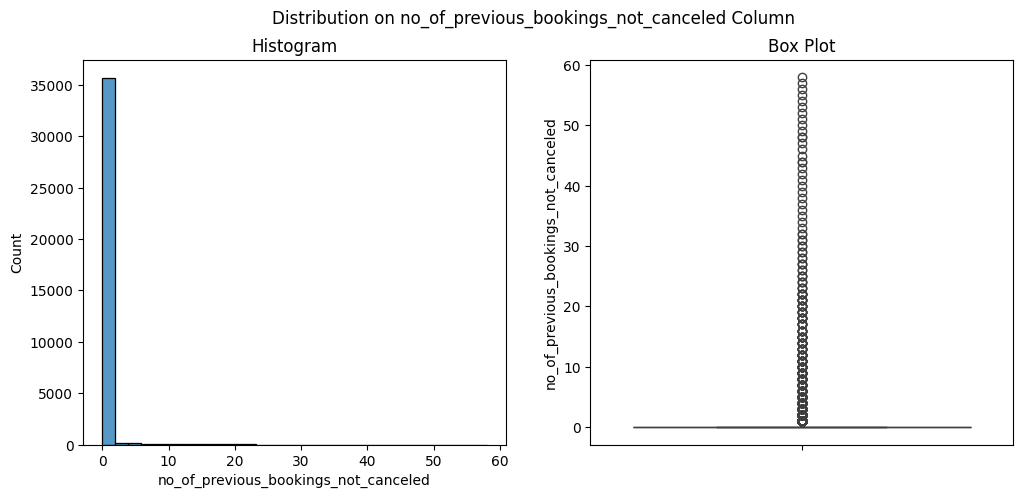

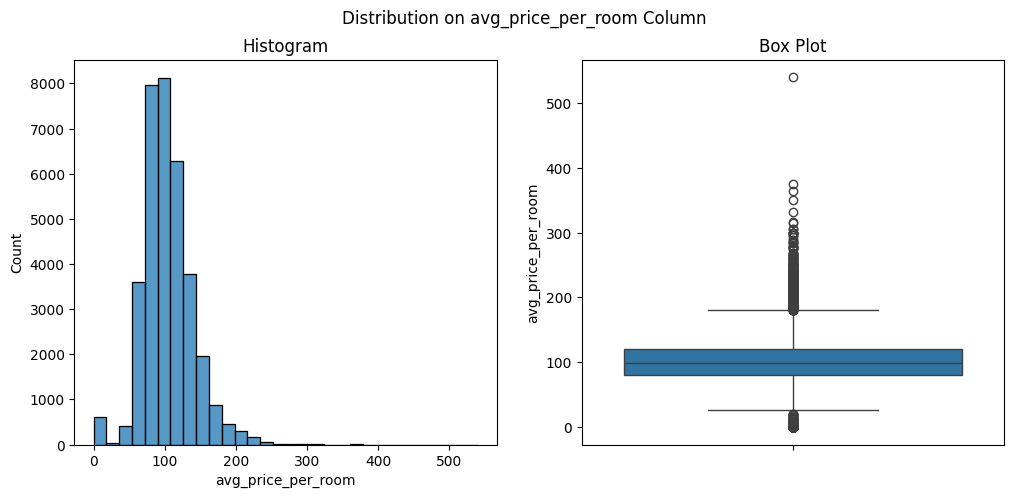

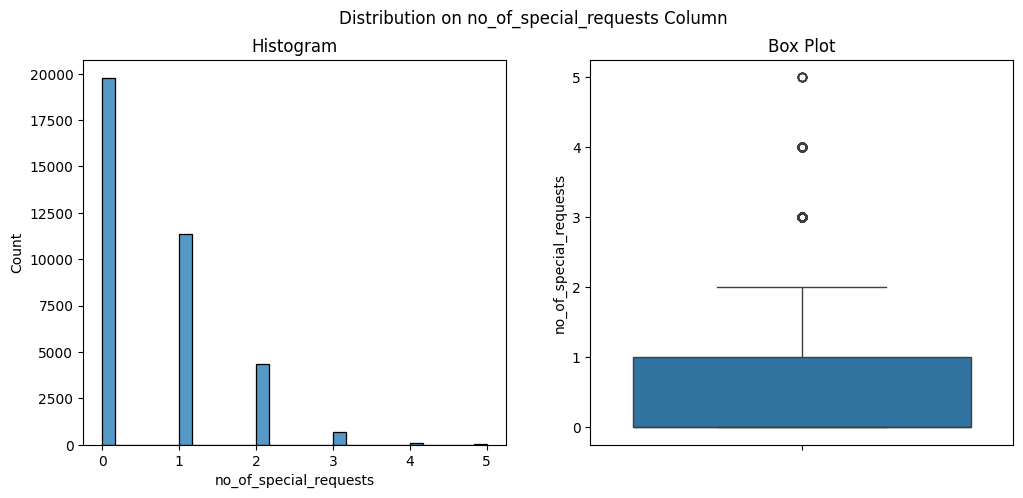

In [63]:
for column in df.select_dtypes(include = ['number']).columns:
    fig, axs = plt.subplots(1, 2, figsize = (12,5))
    plt.title(f"{column} Column")

    sns.histplot(df[column], bins=30, kde=False, ax=axs[0])
    axs[0].set_title('Histogram')

    sns.boxplot(df[column], ax=axs[1])
    axs[1].set_title('Box Plot')

    fig.suptitle(f"Distribution on {column} Column")
    plt.show()

Based on the visualizations from several numerical columns above, we can conclude that most of the columns are : 
1. Have the un-normal distributed data pattern distribution based on histogram
2. Have many data outliers that may become a challange for further processing

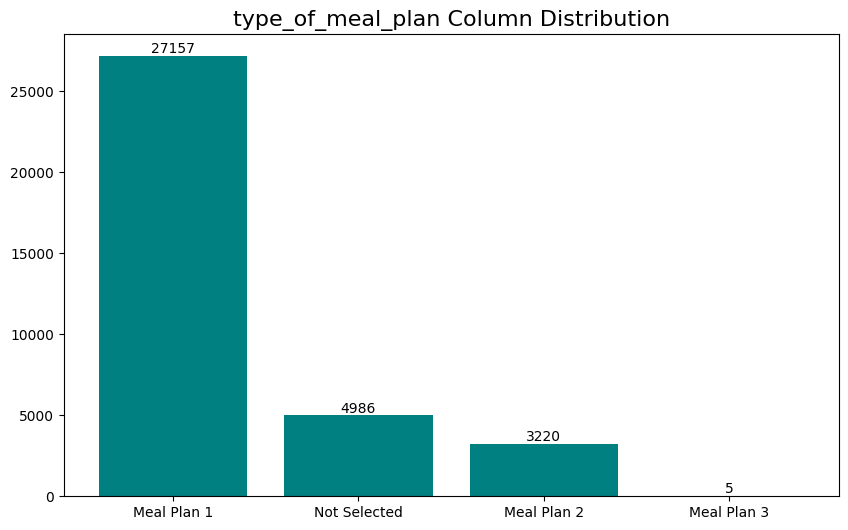

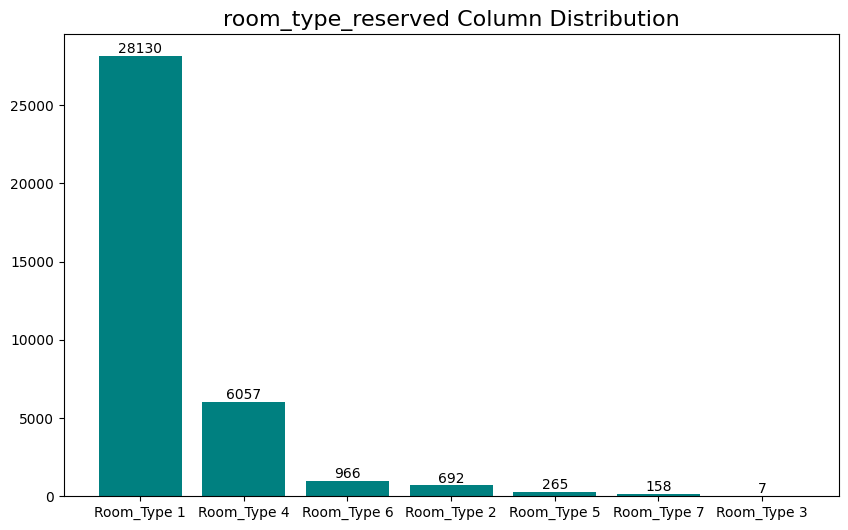

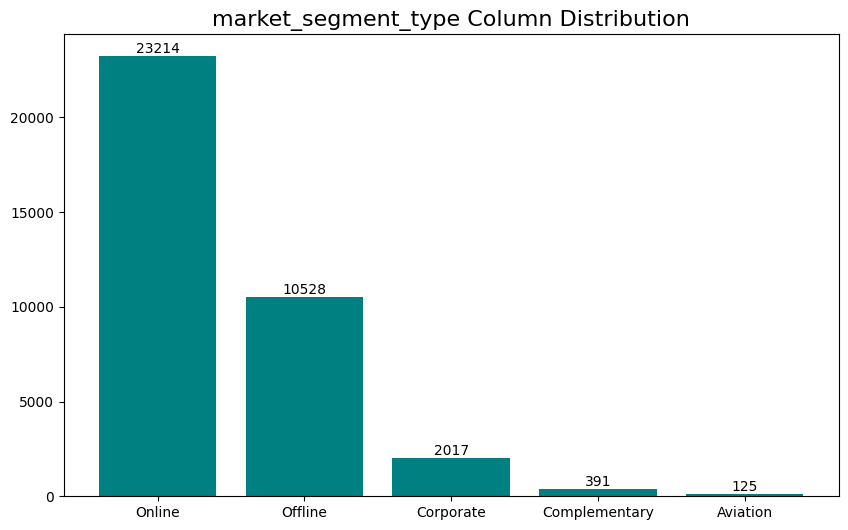

In [204]:
for column in df.select_dtypes(include = ['object']).columns:
    if column != 'booking_status' and column != 'Booking_ID':
        valueCount = df[column].value_counts()
        plt.figure(figsize = (10,6))
        bars = plt.bar(valueCount.index, valueCount.values, color = "teal")
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
        plt.title(f"{column} Column Distribution", size = 16)
        plt.show()

The each unique value, or as well known as the cardinality from each category are not distributed equally, so it may affect for the learning process of the model that can not have a same learning opportunity for each observation

III. Target Variabel Distribution

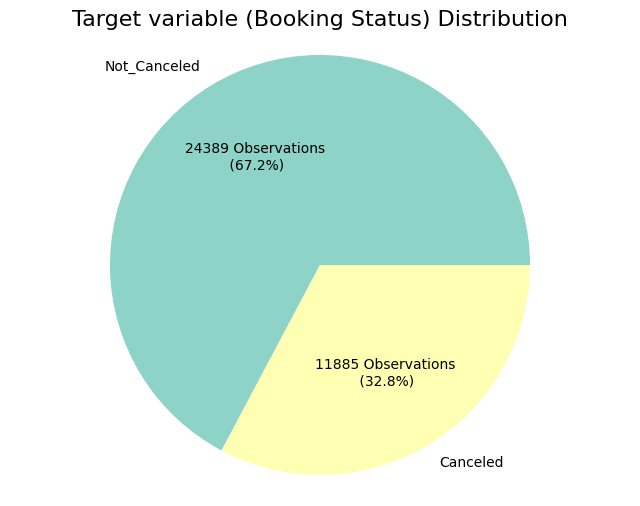

In [65]:
valueCount = df['booking_status'].value_counts()
labels = valueCount.index
sizes = valueCount.values
total_size = sum(sizes)

plt.figure(figsize=(8,6))
plt.pie(sizes, labels = labels, autopct = lambda p: f"{int(p*total_size/100)} Observations\n ({p:.1f}%)", colors = sns.color_palette("Set3", len(valueCount)))
plt.axis('equal')
plt.title(f"Target variable (Booking Status) Distribution", size = 16)
plt.show()

The target variabel also doesnt have an equal distribution, and it also can be affected to the model further on

**DATA TYPE ANOMALIES IDENTIFICATION**

On the numerical dataset, there are several anomalies that we can find out, such as : 
1. Is integer or not, several data, such as the amount of people, place, or other object can not be float
2. Is positive or negative, the price data can not be negative value    

Therefore, we need to create a function to predict whether there are anomalies on each value or not to ensure its consistency

In [66]:
def check_num_anomalies(data):
    return data < 0 or data % 1 != 0

In [67]:
for column in df.select_dtypes(include = ['number']).columns:
    if df[column].apply(check_num_anomalies).any():
        print('Column',column, "Has Anomaly Values")

Column required_car_parking_space Has Anomaly Values
Column avg_price_per_room Has Anomaly Values


In [68]:
df[(df['required_car_parking_space'] % 1 != 0) & (df['required_car_parking_space'].notna())]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status


In [69]:
df[df['avg_price_per_room'] < 0]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status


In [70]:
# Check categorical anomalies
for column in df.select_dtypes(include = ['object']):
    if column != 'Booking_ID':
        print ("Cardinality of", column, "Column")
        print(df[column].value_counts())
        print()

Cardinality of type_of_meal_plan Column
type_of_meal_plan
Meal Plan 1     27157
Not Selected     4986
Meal Plan 2      3220
Meal Plan 3         5
Name: count, dtype: int64

Cardinality of room_type_reserved Column
room_type_reserved
Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64

Cardinality of market_segment_type Column
market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64

Cardinality of booking_status Column
booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64



Each unique value is already consistent each other, and there is not needed further preprocesses to this categorical data.

**NULL VALUES**

In [71]:
null_col = []
for column in df.columns:
    if df[column].isna().sum() > 0:
        print(column, "has", df[column].isna().sum(), "Null values")
        print("Percentage :", df[column].isna().sum()/df.shape[0] * 100,"%")
        print()
        null_col.append(column)

type_of_meal_plan has 907 Null values
Percentage : 2.5003445899379737 %

required_car_parking_space has 1270 Null values
Percentage : 3.5010337698139216 %

avg_price_per_room has 1632 Null values
Percentage : 4.498966230186078 %



Because all of the categories are not exceed 20% proportion from the entire column, so we will do inputation for the missing values

Based on the first visualization, There are two types :   
1. type_of_meal_plan and required_car_parking_space as a categorical variabel, and we will input with the mode value
2. avg_price_per_room as a numerical, but has a lot of outliers, inputation using the median value

In [72]:
for column in null_col:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].median())

In [73]:
null_col_after = []
for column in df.columns:
    if df[column].isna().sum() > 0:
        print(column, "has", df[column].isna().sum(), "Null values")
        print("Percentage :", df[column].isna().sum()/df.shape[0] * 100,"%")
        print()
        null_col_after.append(column)

if not null_col_after:
    print("There are no more null values on the dataset")

There are no more null values on the dataset


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  float64
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

Besides the null values, there are also another type of anomalies that may occurs, which is the data duplicates (when more than 1 observation has the exactly same values) and it will affect to the model if there is any

In [75]:
df = df.drop_duplicates()

Because there is an unique identifier value, which is Booking_ID, we need also find out whethere there is a duplication on booking id or not to avoid the ambiguousness

In [76]:
# Mengidentifikasi duplicate di unique identifier
df['Booking_ID'].value_counts()[df['Booking_ID'].value_counts()>1]

Series([], Name: count, dtype: int64)

Therefore, we can conclude that each observation is proofed as unique and independent  

Before we are going through the model preparation, we will drop the column (Booking_ID) because its stands independently, and subset the numerical and categorical variable to prepare for the encoding

In [77]:
# Unique identifier will not give any impact to the model, because it is stands independently
df = df.drop(columns='Booking_ID')

In [78]:
numerical = df.select_dtypes(include = ['number']).columns.tolist()
categorical = df.select_dtypes(include = ['object']).columns.tolist()

**ENCODING CATEGORICAL VALUES**

A machine learning model is an algorithm that only can accept numerical value for its calculation, therefore, we need to change the categorical values into numerical through the encoding.  

In this case, because we need to deploy the model, so we will use **The Label Encoding**, by manual method and mapping, because we need to know the encoded numerical representation for each cardinality value to be decoded in the streamlit's deployment process

In [79]:
df[categorical]

,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
0,Meal Plan 1,Room_Type 1,Offline,Not_Canceled
1,Not Selected,Room_Type 1,Online,Not_Canceled
2,Meal Plan 1,Room_Type 1,Online,Canceled
3,Meal Plan 1,Room_Type 1,Online,Canceled
4,Not Selected,Room_Type 1,Online,Canceled
...,...,...,...,...
36270,Meal Plan 1,Room_Type 4,Online,Not_Canceled
36271,Meal Plan 1,Room_Type 1,Online,Canceled
36272,Meal Plan 1,Room_Type 1,Online,Not_Canceled
36273,Not Selected,Room_Type 1,Online,Canceled


TYPE OF MEAL PLAN ENCODING VALUES LIST

0 | Not Selected  
1 | Meal Plan 1  
2 | Meal Plan 2  
3 | Meal Plan 3  

In [80]:
mapping_meal = {'Not Selected' : 0, 'Meal Plan 1' : 1, 'Meal Plan 2' : 2, 'Meal Plan 3' : 3}
df['type_of_meal_plan'] = df['type_of_meal_plan'].map(mapping_meal)

TYPE OF ROOM TYPE ENCODING VALUES LIST

1 | Room Type 1  
2 | Room Type 2  
3 | Room Type 3  
4 | Room Type 4  
5 | Room Type 5  
6 | Room Type 6  
7 | Room Type 7

In [81]:
mapping_room = {'Room_Type 1' : 1, 'Room_Type 2' : 2, 'Room_Type 3' : 3, 'Room_Type 4' : 4, 'Room_Type 5' : 5, 'Room_Type 6' : 6, 'Room_Type 7' : 7}
df['room_type_reserved'] = df['room_type_reserved'].map(mapping_room)

TYPE OF MARKET SEGMENT TYPE ENCODING VALUES LIST

1 | Online  
2 | Offline   
3 | Corporate  
4 | Complementary  
5 | Aviation  

In [82]:
mapping_segment = {'Online' : 1, 'Offline' : 2, 'Corporate' : 3, 'Complementary' : 4, 'Aviation' : 5}
df['market_segment_type'] = df['market_segment_type'].map(mapping_segment)

TYPE OF BOOKING STATUS TYPE ENCODING VALUES LIST

0 | Canceled    
1 | Not Canceled  

In [83]:
mapping_status = {'Canceled' : 0, 'Not_Canceled' : 1}
df['booking_status'] = df['booking_status'].map(mapping_status)

In [84]:
df[categorical]

,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
0,1,1,2,1
1,0,1,1,1
2,1,1,1,0
3,1,1,1,0
4,0,1,1,0
...,...,...,...,...
36270,1,4,1,1
36271,1,1,1,0
36272,1,1,1,1
36273,0,1,1,0


In [90]:
for column in categorical:
    print(df[column].value_counts())
    print()

type_of_meal_plan
1    28064
0     4986
2     3220
3        5
Name: count, dtype: int64

room_type_reserved
1    28130
4     6057
6      966
2      692
5      265
7      158
3        7
Name: count, dtype: int64

market_segment_type
1    23214
2    10528
3     2017
4      391
5      125
Name: count, dtype: int64

booking_status
1    24390
0    11885
Name: count, dtype: int64



Therefore, all categorical variables have been encoded, next we need to convert the datatype for each of it to numerical so we can fit it into the model

In [91]:
def convert_num(df):
    df = df.astype(int)

for column in categorical:
    convert_num(df[column])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  int64  
 5   required_car_parking_space            36275 non-null  float64
 6   room_type_reserved                    36275 non-null  int64  
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

The dataset has been ready for the modelling

**SPLIT THE DATASET**

At this moment, we will split the dataset into the **independent (x)** and dependent or **target (y)** variabel.  

After that, we will split each variabel to the train and test dataset, the train aims as a learning material for the model, and test aims to evaluate the model

In [97]:
x = df.drop('booking_status', axis = 1)
y = df['booking_status']

In [98]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [100]:
print("X Train Size :", x_train.shape)
print("Y Train Size :", y_train.shape)
print("X Test Size :", x_test.shape)
print("Y Test Size :", y_test.shape)

X Train Size : (29020, 17)
Y Train Size : (29020,)
X Test Size : (7255, 17)
Y Test Size : (7255,)


**RANDOM FOREST MODEL**

I. The Default Parameter of Random Forest Model

In [114]:
RFModel = RandomForestClassifier(random_state = 42)
RFModel.fit(x_train, y_train)
yhat = RFModel.predict(x_test)

accuracyRF = accuracy_score(y_test, yhat)
accuracyRF

0.9026878015161958

II. Find Out and Fit the Grid Search to a Random Forest Model

In [109]:
RF_ParamGrid = {
    'n_estimators' : [20, 50, 150],
    'max_depth' : [2, 5, 10],
    'min_samples_split' : [1, 5, 8],
    'min_samples_leaf' : [1, 3, 5],
    'max_features' : ['sqrt', 'log2', None],
    'criterion' : ['gini', 'entropy', 'log_loss']
}
gridSearchRF = GridSearchCV(RFModel, param_grid = RF_ParamGrid, scoring = 'accuracy', cv = 5)
gridSearchRF.fit(x_train, y_train)

print("Random Forest Best Parameters :", gridSearchRF.best_params_)

Random Forest Best Parameters : {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}


In [112]:
RFModelGrided = RandomForestClassifier(random_state = 42)
GridedParams = gridSearchRF.best_params_
RFModelGrided.set_params(**GridedParams)
RFModelGrided.fit(x_train, y_train)
yhat2 = RFModelGrided.predict(x_test)
accuracyRFGrided = accuracy_score(y_test, yhat2)
accuracyRFGrided

0.8771881461061337

**XGBOOST MODEL**

I. The Default Parameter of XGBoost Model

In [115]:
XGBModel = xgboost.XGBClassifier(use_label_encoder=False,  eval_metric='mlogloss', random_state = 42)
XGBModel.fit(x_train, y_train)
yhat = XGBModel.predict(x_test)
 
accuracyXGB = accuracy_score(y_test, yhat)
accuracyXGB

0.8897312198483804

II. Find Out and Fit the Grid Search to a XGB Model

In [110]:
XGB_ParamGrid = {
    'n_estimators' : [20, 50, 150],
    'max_depth' : [2, 5, 10],
    'learning_rate' : [0.1, 0.3, 0.5],
    'subsample' : [0.3, 0.6, 1.0],
    'reg_alpha' : [0.1, 0.5, 1],
    'objective' : ['binary:logistic', 'multi:softprob', 'reg:squarederror']
}
gridSearchXGB = GridSearchCV(XGBmodel, param_grid = XGB_ParamGrid, scoring = 'accuracy', cv = 5)
gridSearchXGB.fit(x_train, y_train)

print("XGBOOST Best Parameters :", gridSearchXGB.best_params_)

XGBOOST Best Parameters : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'subsample': 0.6}


In [113]:
XGBModelGrided = xgboost.XGBClassifier(use_label_encoder=False,  eval_metric='mlogloss', random_state = 42)
GridedParams = gridSearchXGB.best_params_
XGBModelGrided.set_params(**GridedParams)
XGBModelGrided.fit(x_train, y_train)
yhat3 = XGBModelGrided.predict(x_test)
accuracyXGBGrided = accuracy_score(y_test, yhat3)
accuracyXGBGrided

0.8991040661612681

**MODEL EVALUATION**

After we fit and evaluate each model, whether the Random Forest and XGBoost (on the default and grid searched), next we will evaluate and compare each accuracy results from each defined model

In [116]:
modelName = ['Default Random Forest', 'Grid Searched Random Forest', 'Default XGBoost', 'Grid Searched XGBoost']
modelAccuracyScore = [accuracyRF, accuracyRFGrided, accuracyXGB, accuracyXGBGrided]

In [128]:
evaluation = pd.DataFrame({
    'Model Name' : modelName, 
    'Accuracy' : modelAccuracyScore
})
evaluation.sort_values(by = 'Accuracy')
evaluation

,Model Name,Accuracy
0,Default Random Forest,0.902688
1,Grid Searched Random Forest,0.877188
2,Default XGBoost,0.889731
3,Grid Searched XGBoost,0.899104


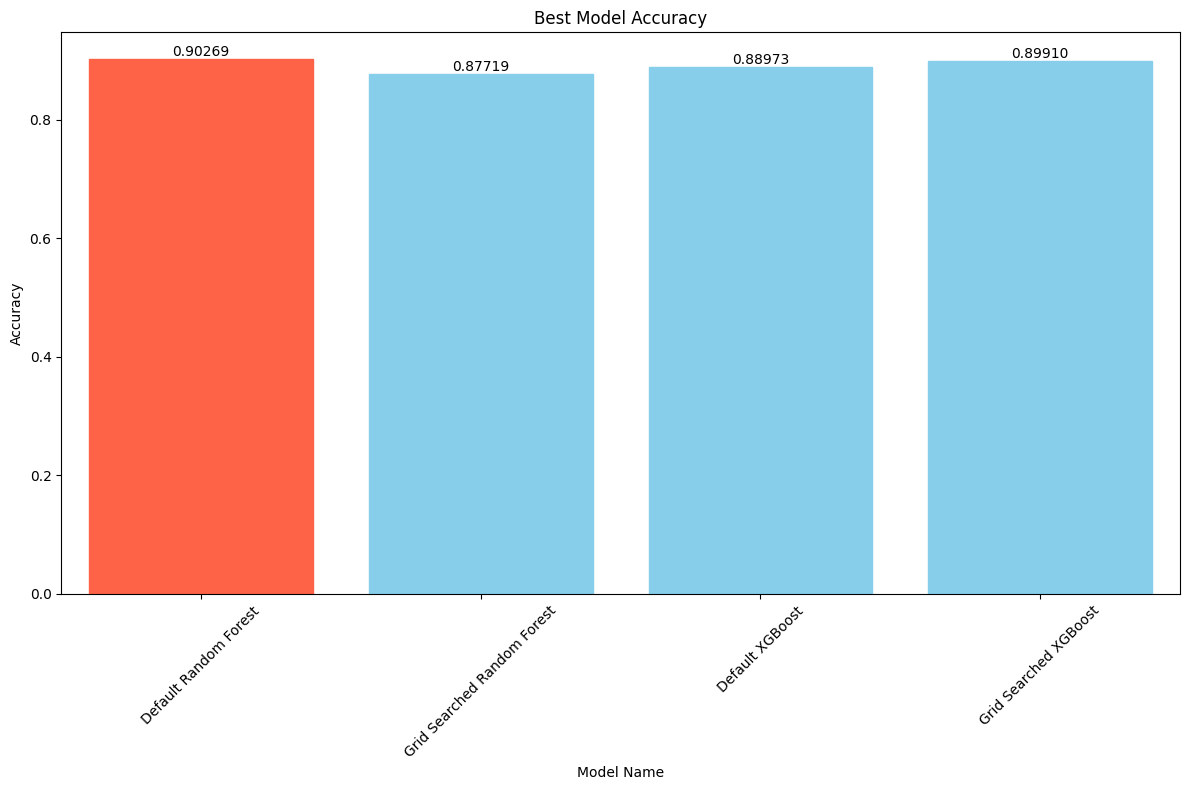

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=evaluation, x='Model Name', y='Accuracy')

max_value = evaluation['Accuracy'].max()

for bar, acc in zip(ax.patches, evaluation['Accuracy']):
    if acc == max_value:
        bar.set_color('tomato')  # Highlight tertinggi
    else:
        bar.set_color('skyblue')  # Sisanya warna default

ax.bar_label(ax.containers[0], fmt='%.5f', fontsize=10, label_type='edge')

plt.xticks(rotation=45)
plt.title("Best Model Accuracy")
plt.tight_layout()
plt.show()

Based on the visualization above, we can conclude that the best model is **Random Forest with Default Parameter**  

Next, we will save the best model with its parameter to the pickle file so it can be used on the deployment.

In [154]:
best_model = RFModel

with open("BestModel.pkl","wb") as file:
    pickle.dump(best_model, file)

print("Best Model has been successfully saved to pickle")

Best Model has been successfully saved to pickle


Find out the scikit-learn version for the usage of streamlit

In [161]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.4.0
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: c:\users\alexander\anaconda3\envs\scala\lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 


**BEST MODEL EVALUATION**

Lastly, we will find out the evaluation metrics for the best model

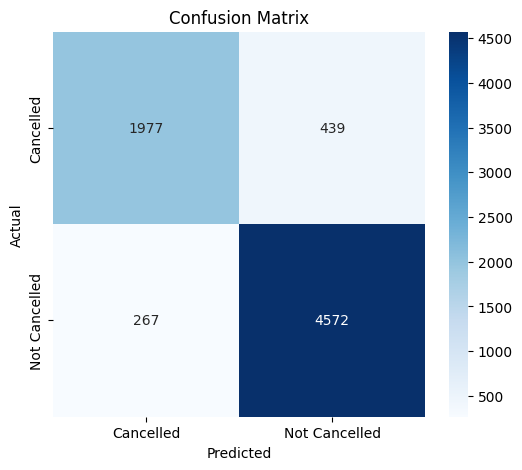

In [195]:
def plot_confusion_matrix(y_true, y_pred, labels= None, label_map = None):
    
    if labels is None:
        labels = sorted(set(y_true) | set(y_pred))

    if label_map is not None:
        labels = [label_map.get(label, str(label)) for label in labels]
        
    cm = confusion_matrix(y_true, y_pred, labels = labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plt.show()

label_map = {0: "Cancelled", 1: "Not Cancelled"}
yhatmapped = pd.Series(yhat).map(label_map)
ytestmapped = pd.Series(y_test).map(label_map)

plot_confusion_matrix(ytestmapped, yhatmapped, label_map = label_map)

Based on the confusion matrix, we can conclude that :  
* There are 4572 values of True Positive
* There are 439 values of False Positive
* There are 267 values of False Negative
* There are 1977 values of True Negative

In [168]:
yhat = RFModel.predict(x_test)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2416
           1       0.91      0.94      0.93      4839

    accuracy                           0.90      7255
   macro avg       0.90      0.88      0.89      7255
weighted avg       0.90      0.90      0.90      7255



**Random Forest Classifier Report Interpretation**  

There are 2 labels as the output, which is : 
1. Label 0 : The Cancelled Booking. From all data, it has 88% true predicted value (Precision), 82% true actual value that has been predicted (Recall), and 85% F1 Score as the overall of precision and recall
2. Label 1 : The Not Cancelled Booking. From all data, it has 91% true predicted value (Precision), 94% true actual value that has been predicted (Recall), and 93% F1 Score as the overall of precision and recall

Therefore, the overall accuracy of the model is 90%, concludes from 7.255 observations, 90% are the true prediction percentage

# ==================================     
## Alexander Rafael  
### 2702256542